In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import matplotlib
import plotly
import sklearn
import torch

from torch import nn, optim

from IPython.display import display
plt.style.use("ggplot")

print("package版本信息：")
print("numpy:      ", np.__version__)
print("pandas:     ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print("seaborn:    ", sns.__version__)
print("plotly:     ", plotly.__version__)
print("PyTorch:     ", torch.__version__)

package版本信息：
numpy:       1.19.2
pandas:      1.2.2
matplotlib:  3.3.4
sklearn:     0.23.2
seaborn:     0.11.1
plotly:      4.14.3
PyTorch:      1.2.0+cpu


# Tensor基础

PyTorch的设计遵循着 **Tensor(高维数组) ——> Varible(自动求导AutoGrad) ——> nn.Module(神经网络层/模块)** 三个由低到高的抽象层次.

## 创建Tensor

有两种方式可以创建Tensor：
1. 使用`torch.Tensor()`构造方法，注意，这是`torch.Tensor`类的构造器方法
2. 使用`torch.xxx()`函数来创建Tensor，比如：
  + `torch.tensor(data, dtype=None, device=None, requires_grad=False,)`——这是静态函数，用于从已有数据中创建tensor，注意这里的`requires_grad`参数。
  + `torch.ones()`
  + `torch.zeros()`
  
上述两种方法都会返回`torch.Tensor`的对象。

有关`torch.Tensor()`方法和`torch.tensor()`方法的讨论见问答 [What is the difference between torch.tensor and torch.Tensor?](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor).

+ 基本创建

In [29]:
# 使用构造方法，指定tensor的shape
t1 = torch.Tensor(2,3)
t1

tensor([[2.9339e+32, 7.5551e+31, 1.5089e-19],
        [4.4656e+30, 3.3917e-15, 0.0000e+00]])

In [154]:
# 使用构造方法，从 list of list 中创建
t2 = torch.Tensor([[1,2,3], [4,5,6]])
t2

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [155]:
# 使用静态方法
t3 = torch.tensor([[1,2]])
t3

tensor([[1, 2]])

+ Tensor的一些属性

In [57]:
t1.dtype

torch.float32

In [30]:
t1.size()

torch.Size([2, 3])

In [31]:
t1.shape

torch.Size([2, 3])

In [32]:
t1.numel()

6

+ 常用的创建方式

In [16]:
# 全 1 Tensor
torch.ones(2,3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [17]:
# 全 0 
torch.zeros(3,2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [18]:
# 步长
torch.arange(1, 6, 2)

tensor([1, 3, 5])

In [19]:
torch.linspace(1, 10, 3)

tensor([ 1.0000,  5.5000, 10.0000])

In [22]:
# 均匀分布随机数
torch.rand(5, 3)

tensor([[0.4395, 0.3174, 0.5914],
        [0.2081, 0.3722, 0.5950],
        [0.5110, 0.2151, 0.0040],
        [0.8960, 0.6777, 0.7021],
        [0.1643, 0.4797, 0.0276]])

In [23]:
# 正态随机数
torch.randn(3,4)

tensor([[-0.8362, -0.4455, -0.4478,  1.5865],
        [ 1.1634,  1.4463,  0.3926,  0.1785],
        [-0.8441, -1.5769, -0.8146,  0.8134]])

In [24]:
# 对角线为1
torch.eye(3,3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

## Tensor类型

Tensor有各种类型，并且每种类型有CPU和GPU版本。

类型之间的转换有三种方式，设已有tensor `a` 和 `b`
1. `a.type(torch.FloatTensor)`，
2. `a.float()`，便捷的方式
3. `a.as_type(b)`，使用`b`的类型来设置`a`

In [61]:
a = torch.tensor([1,2])
a.dtype

torch.int64

In [62]:
c = a.type(torch.FloatTensor)
c.dtype

torch.float32

In [63]:
c = a.float()
c.dtype

torch.float32

## 操作Tensor

神经网络的输入中，特别是RNN模型，常常需要对输入的数据的不同维度进行交换，主要是Batch size 这个维度。  
有两种方式可以处理：
1. `torch.transpose()`
2. `numpy.transpose()`

-----

# Autograd

`torch.autograd` 模块是一套专门用于自动求导的引擎，能够根据输入和前向传播过程自动**动态地**构建计算图，并执行反向传播。

Autograd 模块中的核心数据结构是`Variable`，它是对Tensor的封装，同时记录了对Tensor的操作，用于构建计算图。  
`Variable`包含三个属性：
+ `data`：保存`Variable`包含的Tensor
+ `grad`：保存`data`对应的梯度，它本身也是一个`Variable`，与`data`形状一致
+ `grad_fn`：指向一个Function，记录`Variable`的操作历史，用于构建计算图。对于叶子节点，它指向的None。

注意:
> 从 **0.4 版本**开始，`torch.Tensor`和`torch.autograd.Variable`被合并到了一起。  
更确切地说，`torch.Tensor`能够像旧版`Variable`一样追踪历史，`Variable`封装还像过去那样工作，但返回一个`torch.Tensor`类型的对象。  
这意味着不再需要在代码中到处使用`Variable`封装器。

创建Tensor的时候，有两种方式让这个Tensor作为变量进行求导操作：
1. 创建时指定参数`required_grad=True`
2. 创建后通过`torch.Tensor`对象的`.required_grad`属性进行设置

注意，**只有浮点数类型的Tensor才能设置求导**。

In [138]:
# 下面可以看出，Variable已经和Tensor合并了
from torch.autograd import Variable
a = Variable(torch.ones(2,3)*2, requires_grad=True)
print(a.__class__)
a

<class 'torch.Tensor'>


tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)

----

## 多元函数的反向求导

多元函数是 $R^n \Rightarrow R$ 的一个映射：自变量 $x \in R^n$，因变量 $y=f(x) \in R$. 这种情况下，偏导数 $\frac{\partial f}{\partial x} \in R^n$ 也是一个 $n$ 维向量.  

这里构造一个 $c = 3 \times a^2 + b^2$ 的例子，这个计算中，可以进一步拆成如下的简单四则运算的节点：
1. 节点 $a$ 和 $b$ 都是输入节点——也被称为计算图的**叶子节点**
2. 中间节点 $t_1 = a^2$，$t_2 = b^2$ 和 $t_3 = 3 \times t_1$ —— 对应于计算图的**非叶子节点**
3. 最终的节点 $c = t_3 + t_2$。

下面的代码中，为了简便起见，将 $t_1$ 和 $t_3$ 合并为一个 $t_1 = 3 \times a^2$.

In [228]:
# 注意，这里只能使用 tensor 静态方法，不能使用 torch.Tensor() 构造方法
# 这里必须是 浮点数 1.0，不能是 整数 1
a = torch.tensor([1.0], requires_grad=True)

# 第二种方式指定求导
b = torch.tensor([1.0])
b.requires_grad=True

print("a.requires_grad: ",a.requires_grad)
print("a.grad: ", a.grad)
print("a.grad_fn: ", a.grad_fn)  # 由于 `a` 是手动创建的，所以它的 `grad_fn` 为 None
print("b.requires_grad: ",b.requires_grad)
print("b.grad: ", b.grad)
print("b.grad_fn: ", b.grad_fn)

a.requires_grad:  True
a.grad:  None
a.grad_fn:  None
b.requires_grad:  True
b.grad:  None
b.grad_fn:  None


In [229]:
# 下面的 t1，t2 是显式表示出来的非叶子节点
t1 = 3*a**2
t2 = b**2
c = t1 + t2

print("-----------检查各节点的梯度-------------------")
print("t1.requires_grad: ",t1.requires_grad)
print("t1.grad: ", t1.grad)
print("t1.grad_fn: ",t1.grad_fn)  # t1 是经过计算的（乘法），所以有梯度函数

print("t2.requires_grad: ",t2.requires_grad)
print("t2.grad: ", t2.grad)
print("t2.grad_fn: ",t2.grad_fn)  # t2 是经过计算的（求幂），所以有梯度函数

print("c.requires_grad: ",c.requires_grad)
print("c.grad: ", c.grad)
print("c.grad_fn: ",c.grad_fn)  # c 是经过计算的（加法），所以有梯度函数

# 检查节点是否为叶子节点
print("-----------检查是否为叶子节点----------------")
print("a.is_leaf:", a.is_leaf)
print("b.is_leaf:", b.is_leaf)
print("t1.is_leaf:", t1.is_leaf)
print("t2.is_leaf:", t2.is_leaf)
print("c.is_leaf:", c.is_leaf)

-----------检查各节点的梯度-------------------
t1.requires_grad:  True
t1.grad:  None
t1.grad_fn:  <MulBackward0 object at 0x0000022724238BE0>
t2.requires_grad:  True
t2.grad:  None
t2.grad_fn:  <PowBackward0 object at 0x000002272D296CC0>
c.requires_grad:  True
c.grad:  None
c.grad_fn:  <AddBackward0 object at 0x000002272D2960B8>
-----------检查是否为叶子节点----------------
a.is_leaf: True
b.is_leaf: True
t1.is_leaf: False
t2.is_leaf: False
c.is_leaf: False


上面所有tensor的梯度`.grad`都是None，因为还没有执行过反向求导计算。    
其中 `a` 和 `b` 是**叶子节点**，叶子节点是计算图的起点，所以对应的 `.grad_fn` 总是 None；   
`t1` 代表的 $3\times a^2$ 和 `t2` 代表的 $b^2$ 是**非叶子节点，非叶子节点总是由叶子节点经过层层运算得到**，所以它们的 `.grad_fn` 是对应的上一层的转化操作。

下面从 `c` 所在的节点 关于两个叶子节点 `a` 和 `b` 执行反向求导计算 。  
$\frac{\partial c}{\partial a} = 6a$,   $\frac{\partial c}{\partial b} = 2b$.  
由于tensor `a`=1， `b`=1，代入上述的梯度，就得到 `a.grad`=6, `b.grad`=2.

In [230]:
# 在 c 节点执行反向求导计算
# 如果想再次执行下面的 .backward()，在没有设置参数 retain_graph=True ，只能重新构建一次计算图
# 重新构建计算图有两种方式：
# 第一种：重新赋值，
# c = t1 + t2
# c.backward()
# 另一种是 设置 create_grap=True
c.backward(create_graph=True)

# 设置参数 retain_graph=True，可以多次执行梯度计算，不过这种情况下，叶子节点的梯度就是逐次累加的
# c.backward(retain_graph=True)

print("a.grad: ", a.grad)
print("b.grad: ", b.grad)
print("t1.grad: ", t1.grad)
print("t2.grad: ", t2.grad)
print("c.grad: ", c.grad)

a.grad:  tensor([6.], grad_fn=<CloneBackward>)
b.grad:  tensor([2.], grad_fn=<CloneBackward>)
t1.grad:  None
t2.grad:  None
c.grad:  None


默认下，执行`.backward()`方法会构建从叶子节点到 `c` 节点的计算图，然后反向每个计算节点的梯度。  
默认情况下，为了减少内存占用，**只有叶子节点的梯度会被保留，非叶子节点的梯度在计算完叶子节点的梯度后，会被删除** 。  
**如果想保留计算图中非叶子节点的梯度，需要设置`.backward()`中的参数`retain_graph=True`** 。  
参数`retain_graph=True`时，多次执行`.backward()`函数，**叶子节点的梯度是会累加的**。

上面的`c.backward()`只能执行一次，如果再次执行，就会报错，就是因为计算图中非叶子节点的梯度已经被删除了。

## 向量函数的反向求导

另一种情况是向量函数的偏导数.  
所谓**向量函数**，是 $ R^n \Rightarrow R^m$ 的一个映射：自变量 $x \in R^n $ 是一个 $n$ 维向量，同时因变量 $f(x) = (y_1, y_2,..., y_m)^T \in R^m$ 也是一个 $m$ 维向量，其中的 $y_j = y_j(x) \in R$ 是一个多元函数。 

PyTorch的`autograd`模块有个简单粗暴的规定，**只能执行标量对张量的求导，不能执行张量对张量的求导** 。  
为了对向量函数求偏导数，也就是实现张量对张量的求导，PyTorch的`.backward()`方法里，提供了一个 `grad_variables=` 参数，它是一个 $m$ 维的向量，维度和 $f(x)$ 一样，作用是和 $f(x)$ 做内积，得到一个实数，然后对这个实数变量求偏导数.  
具体来说，就是设 `grad_variables`参数对应的向量是 $v \in R^m$，那么就会得到一个内积值 $l = \sum_{j=1}^{m}{v_j y_j(x)} \in R$，那么就是：  
$\frac{\partial l}{\partial x} = \frac{\partial l}{\partial y}\frac{\partial y}{\partial x}$，其中 $\frac{\partial l}{\partial y} = v \in R^m$，而 $\frac{\partial y}{\partial x} \in R^{m\times n}$ 是一个雅克比矩阵，两者相乘，最后得到的就是一个 $n$ 维的梯度向量.  


下面的例子中, $x \in R^2$, $y = (x+1)^2+3 \in R^2$ 表示对应的分量执行相同的运算，这里相当于 $f(x) \in R^2$，并且  
$
\left\{
\begin{array}\
y_1(x) = y_1(x_1) = (x_1+1)^2+3 \\
y_2(x) = y_2(x_2) = (x_2+1)^2+3
\end{array}
\right.
$,

$
\frac{\partial y}{\partial x} =
\left\{
\begin{matrix}
   \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} \\
   \frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} 
\end{matrix}
\right\}
=
\left\{
\begin{matrix}
   2(x_1+1) & 0 \\
   0 & 2(x_2+1) 
\end{matrix}
\right\}
$.

当 $x=[1, 2]^T$ 时，
$
\frac{\partial y}{\partial x} =
\left\{
\begin{matrix}
   4 & 0 \\
   0 & 6 
\end{matrix}
\right\}
$.

当 `gradient` $=[1, 1]$时，
$
[1, 1]^T \times
\left\{
\begin{matrix}
   4 & 0 \\
   0 & 6 
\end{matrix}
\right\}
= [4, 6]^T
$

In [255]:
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = (x+1)**2+3
print("x:", x)
print("y:", y)
# y 是二维的值，直接调用 .backward() 会报错
y.backward(gradient=torch.tensor([1.0, 1.0]))
print("x.grad: ", x.grad)

x: tensor([1., 2.], requires_grad=True)
y: tensor([ 7., 12.], grad_fn=<AddBackward0>)
x.grad:  tensor([4., 6.])


当 `gradient` $=[1, 2]$时，
$
[1, 2]^T \times
\left\{
\begin{matrix}
   4 & 0 \\
   0 & 6 
\end{matrix}
\right\}
= [4, 12]^T
$

In [256]:
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = (x+1)**2+3
# gradient = [1, 2]
y.backward(gradient=torch.tensor([1.0, 2.0]))
print("x.grad: ", x.grad)

x.grad:  tensor([ 4., 12.])


In [257]:
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = (x+1)**2+3
# gradient = [2, 1]
y.backward(gradient=torch.tensor([2.0, 1.0]))
print("x.grad: ", x.grad)

x.grad:  tensor([8., 6.])


## 自定义函数的反向求导-TODO

-----

# 神经网络模块`nn.Module`

使用PyTorch的`nn.Module`模块构建神经网络的过程如下图所示.

<img src="images/pytorch-nn.module.png" width="75%" align="left">

## 构建神经网络

实际使用中，构建神经网络的最常见做法是继承 `nn.Module` 类，在其中定义自己的网络结构。

`torch.nn`中的核心结构是`Module`，它是一个抽象的概念，既可以表示神经网络中的某个层，还可以表示包含很多层的神经网络。

构建一个神经网络，有如下几步：
1. 继承 `nn.Module` 抽象基类，
2. 在初始化方法`__init__()`中，存放网络中可学习的参数，并使用`nn.Parameters()`封装
3. 实现`nn.Module`抽象类中的前向传播方法`forward()`，梯度的反向传播方法不需要自己写，PyTorch会自动生成
4. 调用时可以是 `net.forward(X)`，也可以直接使用 `net(X)`
5. 网络的可学习参数可以通过网络实例对象的`.parameters()` 或者 `.named_parameters()` 返回

下面的例子是**构建一个线性（没有激活函数）的全连接层，也就是 $y=Wx+b$**.

In [171]:
# 构建一个线性的网络
from torch import nn

class LinearNN(nn.Module):
    # 构造函数
    def __init__(self, dim_input, dim_output):
        # 调用父类的构造函数
        super().__init__()
        # 再初始化自己的参数
        # 随机初始化参数矩阵W
        self.w = nn.Parameter(torch.randn(dim_input, dim_output))
        # 随机初始化偏置项
        self.b = nn.Parameter(torch.randn(dim_output))
        
    # 实现抽象类 nn.Module 的 forward 方法
    def forward(self, X):
        """
        前向传播过程
        """
        y = X.mm(self.w) + self.b
        return y

In [172]:
linear = LinearNN(dim_input=3, dim_output=2)

for param, value in linear.named_parameters():
    print(param)
    print(value)

w
Parameter containing:
tensor([[ 0.6475, -0.4241],
        [-0.1332, -1.3617],
        [ 0.3725,  1.7960]], requires_grad=True)
b
Parameter containing:
tensor([0.4546, 2.4694], requires_grad=True)


In [173]:
X = torch.randn(4,3)
X

tensor([[-0.1510,  0.3097, -1.4704],
        [-0.1441,  0.3727,  0.6084],
        [-1.0195, -1.2713,  0.2241],
        [ 2.6327,  0.1713,  1.1290]])

In [177]:
# 显式调用 forward 方法
# y_out = linear.forward(X)

# 也可以直接调用
y_out = linear(X)

y_out

tensor([[-0.2322, -0.5291],
        [ 0.5383,  3.1157],
        [ 0.0472,  5.0352],
        [ 2.5571,  3.1473]], grad_fn=<AddBackward0>)

-----------

## 常用的神经网络模块-KEY

### 全连接层

`nn.Linear(in_features: int, out_features: int, bias: bool = True)` .  
计算的是 $y=XW^T+b$，其中 $X$的维度是$batch\_size \times in\_features$, $W$的维度是 $out\_features \times in\_features$.
+ 初始化参数：
  + `in_features`：**int**，输入数据的维度
  + `out_features`: **int**，输出数据的维度
  + `bias`：是否有偏置项
  

+ `forward()`方法参数：
  + 输入参数`Input`：$(batch\_size, * , in\_features)$, `*` 是中间维度（没啥用）
  + 返回参数`Output`：$(batch\_size, *, out\_features)$
  

+ 属性
  + `.weight`：权重矩阵
  + `.bias`：偏置项

In [183]:
linear_model = nn.Linear(in_features=3, out_features=2)

print("weight:")
print(linear_model.weight)
print("bias:")
print(linear_model.bias)

weight:
Parameter containing:
tensor([[ 0.1275, -0.4422,  0.2409],
        [ 0.1011,  0.2749,  0.1577]], requires_grad=True)
bias:
Parameter containing:
tensor([-0.1225, -0.1347], requires_grad=True)


In [181]:
X = torch.randn(4,3)
X

tensor([[-2.3011,  0.3329,  1.7874],
        [-0.3963,  0.6201, -0.1444],
        [ 1.4532,  1.7288, -0.6337],
        [ 1.1768,  0.4847,  2.3175]])

In [185]:
y_out = linear_model(X)
y_out

tensor([[-0.1325,  0.0059],
        [-0.4821, -0.0270],
        [-0.8543,  0.3876],
        [ 0.3715,  0.4830]], grad_fn=<AddmmBackward>)

### Softmax层

+ `nn.Softmax(dim)`

+ `nn.LogSofrmax(dim)`

`dim`参数指定计算的轴维度。

In [192]:
X = torch.randn(4, 5)
X

tensor([[-0.1051, -0.6662, -1.5944,  1.7258, -1.1150],
        [-1.9155, -0.5558,  1.1335, -0.5306, -1.0881],
        [-0.2570, -0.6757, -0.7405, -0.3356, -0.2761],
        [ 1.0059, -0.0551,  0.2353,  0.7235, -0.1148]])

In [193]:
softmax = nn.Softmax(dim=1)
softmax(X)

tensor([[0.1191, 0.0679, 0.0268, 0.7428, 0.0434],
        [0.0310, 0.1207, 0.6536, 0.1238, 0.0709],
        [0.2392, 0.1574, 0.1475, 0.2212, 0.2347],
        [0.3462, 0.1198, 0.1602, 0.2610, 0.1129]])

In [194]:
logsoft = nn.LogSoftmax(dim=1)
logsoft(X)

tensor([[-2.1282, -2.6893, -3.6175, -0.2973, -3.1382],
        [-3.4741, -2.1144, -0.4252, -2.0892, -2.6468],
        [-1.4303, -1.8490, -1.9138, -1.5089, -1.4494],
        [-1.0608, -2.1219, -1.8315, -1.3433, -2.1815]])

### CNN相关

+ 卷积层  
`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')` .  
这里不能指定卷积核，只能指定卷积核的`kernel_size`


+ 偏置项


+ 池化层  
`nn.MaxPool2d(kernel_size, stride = None, padding = 0, dilation = 1, return_indices = False, ceil_mode = False)`

In [195]:
# 输入的是 2张 4x4x3 的图片，这里为了容易辨别，将通道数3提前了一点
imgs = np.arange(2*4*4*3,dtype=np.float32).reshape((2,3,4,4))
imgs_tensor = torch.tensor(imgs)
display(imgs)

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[16., 17., 18., 19.],
         [20., 21., 22., 23.],
         [24., 25., 26., 27.],
         [28., 29., 30., 31.]],

        [[32., 33., 34., 35.],
         [36., 37., 38., 39.],
         [40., 41., 42., 43.],
         [44., 45., 46., 47.]]],


       [[[48., 49., 50., 51.],
         [52., 53., 54., 55.],
         [56., 57., 58., 59.],
         [60., 61., 62., 63.]],

        [[64., 65., 66., 67.],
         [68., 69., 70., 71.],
         [72., 73., 74., 75.],
         [76., 77., 78., 79.]],

        [[80., 81., 82., 83.],
         [84., 85., 86., 87.],
         [88., 89., 90., 91.],
         [92., 93., 94., 95.]]]], dtype=float32)

### RNN相关

pytorch中RNN相关的支持分为三类：
1. `nn.RNNBase`，RNN的基础抽象类
2. RNN的单个Cell类，处理序列中的单独一步
  + `nn.RNNCell`
  + `nn.GRUCell`
  + `nn.LSTMCell`
3. RNN的单元封装类，处理整个序列，它是对RNN Cell类的封装，可以**构建多层RNN**
  + `nn.RNN`
  + `nn.GRU`
  + `nn.LSTM`


RNN处理的是序列数据，所以输入数据的维度中，多了一个 sequence 维度（或者叫 time_step ），所以输入的数据shape是 `(batch_size, seq_length, in_features)`。

+ 以文本处理为例：
  + 一般将一个句子看做一个sequence，而句子中的每个单词都用一个词向量来表示，那么一个句子就是一个矩阵 $v \times s$，$v$ 是词向量的长度——所有单词都是一样的，$s$ 是这个句子里单词的数量——一个序列的长度。  
  + 但是文本中，不是所有的句子长度 $s$ 都是一样的，需要做进一步的处理 —— 选择最大的句子长度（或者平均长度）为准，所有的句子都规范化成这个长度，超过的部分截断，不足的部分单词补0——这个补充的单词0也对应于一个词向量，这样就得到了形状规范的一个 sequence 样本。   
  + 每个 sequence 对于RNN 来说是一个样本，每次训练使用多个，也就是 batch_size。
  

+ pytorch中构建**一层**RNN的时候，需要配置的参数有如下几个：
  + `in_features`——对应于输入层的节点数
  + `hidden_units`——隐藏层节点数，也就是状态向量的长度
  + **序列长度这个参数不需要设置，它直接从样本中推断即可**

In [5]:
from torch import nn

In [7]:
# 构建一个 单层、单向 RNN
# 需要设置的两个参数：输入特征数为5，隐藏层状态向量长度=3
# 由数据决定的两个参数：batch_size=2，序列长度=4
in_features = 5
hidden_size = 3
num_layers = 1
rnn_layer = nn.RNN(input_size=in_features, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, nonlinearity='relu', bias=False, batch_first=True)
rnn_layer

RNN(5, 3, bias=False, batch_first=True)

In [9]:
# 输入的数据shape应当为 (batch_size, seq_length, in_features)
batch_size = 2
seq_length = 4
rnn_data = torch.randn(batch_size, seq_length, in_features)
rnn_data.shape

torch.Size([2, 4, 5])

In [16]:
# 输入数据
# 这里只输入了训练数据，没有输入 隐藏层状态的初始化参数 h_0（可以省略）
rnn_result = rnn_layer(input=rnn_data)

In [20]:
# 结果是一个 长度=2 的tuple
print(rnn_result.__class__)
print(len(rnn_result))

# 第一个是 output，它的 shape = (batch_size, seq_length, hidden_size*num_directions)
print(rnn_result[0].shape)

# 第二个是 h_n，表示各隐藏层的状态，shape=(num_layers*num_directions, batch_size, hidden_size)
print(rnn_result[1].shape)

<class 'tuple'>
2
torch.Size([2, 4, 3])
torch.Size([1, 2, 3])


----------

## 激活函数

PyTorch中，激活函数也被封装成了一个单独的层来使用

-----------

## 损失函数

构建完神经网络的前向传播过程之后，需要计算神经网络输出的损失。

PyTorch中，损失函数也位于 `nn.Module`这个模块中。

损失函数有两种使用方式

### MSE
`nn.MSELoss()`类，它实例化的对象接受的参数为`(Input, Target)`，`Input`和`Target`的shape必须是相同的，**可以是矩阵，此时计算的MSE就是矩阵对应元素之间的MSE**.

In [47]:
mse = nn.MSELoss()

In [81]:
# shape=(3,)
y_true = torch.tensor([1,2,3], dtype=torch.float)
y_pred = torch.tensor([3,4,5], dtype=torch.float, requires_grad=True)

# shape=(3,1)
# y_true = torch.tensor([[1], [2], [3]], dtype=torch.float)
# y_pred = torch.tensor([[3], [4], [5]], dtype=torch.float, requires_grad=True)

loss = mse(y_pred, y_true)

print("y_true:")
print(y_true)
print("y_pred:")
print(y_pred)

print("MSE-Loss:")
print(loss)

y_true:
tensor([1., 2., 3.])
y_pred:
tensor([3., 4., 5.], requires_grad=True)
MSE-Loss:
tensor(4., grad_fn=<MseLossBackward>)


+ 下面这个矩阵计算的就是对应位置元素的MSE   
$mse = (0+1+0+1+0+1)/6=\frac{3}{6}=0.5$

In [80]:
y_true = torch.tensor([[1,2], [2,3], [3,4]], dtype=torch.float)
y_pred = torch.tensor([[1,3], [2,4], [3,5]], dtype=torch.float, requires_grad=True)
# y_pred = torch.tensor([[1,4], [2,5], [3,6]], dtype=torch.float, requires_grad=True)

loss = mse(y_pred, y_true)

print("y_true:")
print(y_true)
print("y_pred:")
print(y_pred)

print("MSE-Loss:")
print(loss)

y_true:
tensor([[1., 2.],
        [2., 3.],
        [3., 4.]])
y_pred:
tensor([[1., 3.],
        [2., 4.],
        [3., 5.]], requires_grad=True)
MSE-Loss:
tensor(0.5000, grad_fn=<MseLossBackward>)


### 对数似然误差

对数似然误差(Negative Log Likelihood Loss, 缩写为**NLLL**)对应的类是 `nn.NLLLoss()`，通常用于多分类问题 .    

它实例化的对象接受的参数为`(Input, Target)`：
+ `Input`的 `shape=(batch_size, C)`，$C$ 是类别的个数。其中每一行的值应当是经过 softmax 之后 取对数的结果——也就是所谓的 Log Likelihood.
+ `Target`的 `shape=(batch_size)`

这个类的构造函数里有一个 `reduction='mean'` 的参数，表示会将得到的结果进行reduce，方式是取均值。

In [4]:
y_true = torch.tensor([1, 0, 0], dtype=torch.long)
y_pred = torch.tensor([[1,0], [1,0], [0,1]], dtype=torch.float, requires_grad=True)

print("y_true.shape: ", y_true.shape)
print("y_true:")
print(y_true)
print("\ny_pred.shape: ", y_pred.shape)
print("y_pred:")
print(y_pred)

nll = nn.NLLLoss(reduction='none') # 关闭 reduce
loss = nll(y_pred, y_true)

print("\nNegative-Likehood-Log-Loss (关闭 reduce):")
print(loss)

nll = nn.NLLLoss() # 打开 reduce，默认为mean
loss = nll(y_pred, y_true)

print("\nNegative-Likehood-Log-Loss (reduce='mean'):")
print(loss)

y_true.shape:  torch.Size([3])
y_true:
tensor([1, 0, 0])

y_pred.shape:  torch.Size([3, 2])
y_pred:
tensor([[1., 0.],
        [1., 0.],
        [0., 1.]], requires_grad=True)

Negative-Likehood-Log-Loss (关闭 reduce):
tensor([-0., -1., -0.], grad_fn=<NllLossBackward>)

Negative-Likehood-Log-Loss (reduce='mean'):
tensor(-0.3333, grad_fn=<NllLossBackward>)


上面的例子演示了该损失函数的工作方式： 
+ 对于一个二分类的问题，有 3 个样本，
+ 输入的 `y_true.shape=[3]`，每个元素是实际的类别 0 或 1。如果是多分类，有 $C$ 个类别，那么取值就是 $[0, C-1]$.
+ 输入的 `y_pred.shape=[3, 2]`, 每一行是长度=2的向量，向量的每个值对应于取该类别的概率——**实际输入时这个应该是经过 softmax + log 之后的 log likelyhood**。
+ 在 `reduce='none'`时，NLLLoss 会将 `y_true` 看做 `y_pred` 中每一行的索引，取出其中的值，并加上 负号。  
这是因为 `y_true`中的元素取值为 $[0, C-1]$，就是 `y_pred` 每一行的长度，用于从中获得该样本取每一类的对数概率。
+ `reduce='mean'`时，就是将上述结果进行聚合。

实际中使用时，NLLOSS 的输入通常是经过 `nn.LogSoftmax` 变换得到的，下面是一个完整的例子（源自官方文档）。

In [7]:
# NLLoss损失函数官方示例
logsoftmax = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()

# 输入的 size N x C = 3 x 5， 表示 3 个样本，类别是 5 类
input = torch.randn(3, 5, requires_grad=True)
print("input_tensor:\n", input)

# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])

# 先对 input 做 softmax + log 变换，每一行表示取各个类别的对数概率
logsoftmax_out = logsoftmax(input)
print("\n LogSoftmax out:\n", logsoftmax_out)

# 将 LogSoftmax 的结果作为 输入
output = loss(logsoftmax_out, target)
print("\n NLLoss out:\n", output)

input_tensor:
 tensor([[-0.7142, -1.4875, -0.9207, -0.1043, -0.0645],
        [ 0.5339,  0.2950,  0.4972, -0.7490,  1.0334],
        [-0.2580, -1.1683, -0.9682, -0.8448, -0.2316]], requires_grad=True)

 LogSoftmax out:
 tensor([[-1.7968, -2.5701, -2.0033, -1.1869, -1.1470],
        [-1.5426, -1.7815, -1.5793, -2.8255, -1.0430],
        [-1.2461, -2.1564, -1.9563, -1.8329, -1.2197]],
       grad_fn=<LogSoftmaxBackward>)

 NLLoss out:
 tensor(1.7775, grad_fn=<NllLossBackward>)


### 交叉熵误差

`nn.CrossEntropyLoss()`可以用于多分类问题，它就是对 `nn.LogSoftmax` + `nn.NLLLoss` 的封装 .    
它实例化的对象接受的参数为`(Input, Target)`：
+ `Input`的 `shape=(batch_size, C)`，$C$ 是类别的个数
+ `Target`的 `shape=(batch_size)`

In [96]:
crossEnt = nn.CrossEntropyLoss()

In [97]:
y_true = torch.tensor([1, 0, 0], dtype=torch.long)
y_pred = torch.tensor([[1,0], [1,0], [0,1]], dtype=torch.float, requires_grad=True)

print("y_true.shape: ", y_true.shape)
print("y_true:")
print(y_true)
print("\ny_pred.shape: ", y_pred.shape)
print("y_pred:")
print(y_pred)

loss = crossEnt(y_pred, y_true)

print("\nNegative-Likehood-Log-Loss:")
print(loss)

y_true.shape:  torch.Size([3])
y_true:
tensor([1, 0, 0])

y_pred.shape:  torch.Size([3, 2])
y_pred:
tensor([[1., 0.],
        [1., 0.],
        [0., 1.]], requires_grad=True)

Negative-Likehood-Log-Loss:
tensor(0.9799, grad_fn=<NllLossBackward>)


-------------

# 优化器

计算完神经网络前向传播的损失函数之后，需要使用PyTorch里的优化器模块 `torch.optim` 对损失函数进行反向求导，更新梯度.

## 优化器使用

+ 构造优化器  
构造一个优化器，通常要传入模型的参数、学习率等参数
```python
model = nn.Linear(3,2)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
```


+ 使用优化器来更新梯度  
调用优化器对象的`.step()`方法来更新梯度参数，更新参数之前，必须要进行反向求导的操作，也就是调用`.backward()`方法。  
一个常用的简化版本如下：
```python
# 构造模型
model = nn.Linear(3,2)
# 构造模型对应的优化器
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# 在数据集上分批次迭代
for input, target in dataset:
    # 清空梯度
    optimizer.zero_grad()
    # 获取输出
    output = model(input)
    # 计算损失
    loss = loss_fn(output, target)
    # 反向求导，计算每个参数的梯度
    loss.backward()
    # 调用优化器进行梯度更新
    optimizer.step()
```

可以参考StackOverflow回答 [pytorch - connection between loss.backward() and optimizer.step()](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step/66192315#66192315).

注意：`loss.backward()` **这一步不是必须的，如果没有计算梯度，那么调用`optimizer.step()`时，不会对参数进行更新**。

下面以函数 $z = 3x^2 + y^3$ 为例，介绍PyTorch中反向更新的方式.  
$z$ 关于 $x$ 和 $y$ 的梯度更新公式分别为：  
$x := x - \alpha \frac{\partial z}{\partial x} = x - \alpha 6x$,   
$y := y - \alpha \frac{\partial z}{\partial y} = y - \alpha 3y^2$.  
初始值分别为：$x=1$ 和 $y=2$.

In [270]:
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)
z = 3*x**2+y**3

# 初始时梯度均为 None
print("x.grad: ", x.grad)
print("y.grad: ", y.grad)
print("z.grad: ", z.grad)

x.grad:  None
y.grad:  None
z.grad:  None


计算 $x=1$ 和 $y=2$ 时的梯度，分别为 $\frac{\partial z}{\partial x} = 6x = 6, \frac{\partial z}{\partial y} = 3y^2 = 12$.

In [249]:
# 计算梯度
z.backward()
print("x.grad: ", x.grad)
print("y.grad: ", y.grad)
print("z.grad: ", z.grad)

x.grad:  tensor([6.])
y.grad:  tensor([12.])
z.grad:  None


执行一次梯度更新操作，也就是基于梯度的反方向，更新 $x$ 和 $y$，这里学习率 $\alpha=0.1$.  
$x := x - \alpha \frac{\partial z}{\partial x} = x - 0.1 \times 6x = 1 - 0.1 \times 6 = 0.4$,   
$y := y - \alpha \frac{\partial z}{\partial y} = y - 0.1 \times 3y^2 = 2 - 0.1 \times 12 = 0.8$. 

**如果没有执行上面的`.backward()`这一步计算梯度，那么下面就不会更新参数值**。

In [271]:
# 将要更新的参数x,y传入优化器，学习率设置为0.1
optimizer = optim.SGD([x, y], lr=0.1)
# 根据已有的梯度，更新x,y
optimizer.step()

# 更新之后的x和y
print("x:", x)
print("y:", y)

x: tensor([1.], requires_grad=True)
y: tensor([2.], requires_grad=True)


## 动态学习率

`torch.optim.lr_scheduler`子模块提供了随着训练epoch改变的动态学习率设置。

+ `optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1, verbose=False)`  
  **用于自定义学习率随着训练epoch变化的情况**。
  + `optimizer`，传入的`optimizer`对象
  + `lr_lambda`，用于设置随着epoch的学习速率，有两种方式：
    1. fuction：直接设置的函数
    2. list of function，每个函数对应于一组参数
  + `last_epoch`
  

+ `optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1, verbose=False)`  
  **等间隔调整学习率**，每隔 step_size 个 epoch，将学习率更新为原来的 gamma 倍.

+ `optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1, verbose=False)`  
按指数衰减调整学习率，调整公式: $lr = lr \times gamma^{-epoch}$


In [272]:
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)
z = 3*x**2+y**3

# 创建优化器
optimizer = optim.SGD([x, y], lr=0.1)

# 自定义根据 epoch 来计算学习率的 lambda 函数
lambda1 = lambda epoch: np.ceil(epoch/5)

# 然后创建一个更新优化器中学习率的schduler对象
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# 打印每轮中的学习率参数
for epoch in range(1, 21):
    
    # 这里没有指定.backward()方法计算梯度，所以每一轮中不会对参数进行更新
    
    # 先调用优化器的step
    optimizer.step()
    # 再调用 scheduler 更新学习率
    scheduler.step()
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    if epoch % 5 == 0:print()

Epoch-1 lr: 0.1
Epoch-2 lr: 0.1
Epoch-3 lr: 0.1
Epoch-4 lr: 0.1
Epoch-5 lr: 0.1

Epoch-6 lr: 0.2
Epoch-7 lr: 0.2
Epoch-8 lr: 0.2
Epoch-9 lr: 0.2
Epoch-10 lr: 0.2

Epoch-11 lr: 0.30000000000000004
Epoch-12 lr: 0.30000000000000004
Epoch-13 lr: 0.30000000000000004
Epoch-14 lr: 0.30000000000000004
Epoch-15 lr: 0.30000000000000004

Epoch-16 lr: 0.4
Epoch-17 lr: 0.4
Epoch-18 lr: 0.4
Epoch-19 lr: 0.4
Epoch-20 lr: 0.4



## 正则化

PyTorch中的正则化也是在`optim`模块中实现的，不过optimizer只能实现L2正则化，L1正则化只能手动实现.  
optimizer优化器的参数`weight_decay (float, optional)`就是 L2 正则项，它的默认值为0.

可以参考如下讨论：
+ [Simple L2 regularization?](https://discuss.pytorch.org/t/simple-l2-regularization/139)
+ [Adding L1/L2 regularization in PyTorch?](https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch)

----

# 数据加载和变换

详细说明可以参考官方文档 [WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

一般训练的时候，需要对数据进行分batch进行，为了更方便的提供数据，Pytorch提供了 `torch.utils.data` 包用于辅助处理数据。  
这里面主要有两个类：
1. `data.DataSet()`，一个抽象类，提供对数据的封装。
2. `data.DataLoader()`，在 `DataSet`上进行迭代，每次返回一个 batch 的数据，并且可以实现 shuffle 和 多进程读取。

+ 自定义数据集需要做如下步骤：
  1. 编写一个类，继承`data.DataSet`类
  2. 实现`__len__()`方法和 `__getitem__()` 方法
  
  
+ 自定义数据集类之后，只需要将它传递给`data.DataLoader()`类作为初始化参数即可返回一个可迭代的对象，在此对象上执行分批操作即可.

---------

# GPU加速

In [508]:
# 检查当前是否有可用的 CUDA 环境
torch.cuda.is_available()

True

In [509]:
# 返回当前使用的 CUDA设备的 id
torch.cuda.current_device()

0

In [510]:
# 检查一共有多少块 CUDA设备 可用
torch.cuda.device_count()

1

In [511]:
# 获取 CUDA设备ID 对应的设备名称
torch.cuda.get_device_name(0)

'GeForce RTX 2060'

In [523]:
# 指定设备
# 指定CPU设备
device_cpu = torch.device("cpu")
# 指定GPU设备
device_gpu = torch.device("cuda:0")
print(device_cpu)
print(device_gpu)

cpu
cuda:0


In [526]:
# 常用的一个用法是
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [83]:
# 释放占用的显存
torch.cuda.empty_cache()

---------------

# PyTorch示例

## 神经网络示例

作为示例，实现如下的一个简单神经网络，**它只有一个隐藏层，并且隐藏层没有使用激活函数。**

<img src="images/f2.png" width="70%" align="left">

### 构建网络的前向传播过程

In [149]:
from torch import nn

class Perceptron(nn.Module):
    """
    两层的感知机模型
    """
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.w1 = nn.Parameter(torch.randn(dim_input, dim_hidden))
        # 这里输出层本来应当是一个单元，但是作为分类问题，需要输出二分类下，各个类的概率，所以输出层也为2
        self.w2 = nn.Parameter(torch.randn(dim_hidden, 2))
        
    def forward(self, x):
        """
        神经网络的前向传播函数
        x: 输入的Tensor
        """
        # print("x.shape: ", x.shape)
        # print("w1.shape: ", self.w1.shape)
        layer = x.mm(self.w1)
        output = layer.mm(self.w2)
        return output

### 模拟数据

In [122]:
# 使用numpy随机模拟数据
from numpy.random import RandomState

rnd = RandomState(29)
datasize = 128
# 随机生成 datesize x 2 的矩阵
X = rnd.rand(datasize,2)
# 对于X中的每一行，计算一个对于的 y_true 值，
# y_true = np.array([ [int(x1+x2<1)] for (x1,x2) in X])
y_true = np.array([ int(x1+x2<1) for (x1,x2) in X])

print("X.shape: ", X.shape)
print("X:\n",X[:5,:])
print("\ny_true.shape: ", y_true.shape)
print("y_true:\n",y_true[:5])

X.shape:  (128, 2)
X:
 [[0.86375999 0.28490597]
 [0.07325639 0.7632372 ]
 [0.45271906 0.54229687]
 [0.72663578 0.84890511]
 [0.76819998 0.73314372]]

y_true.shape:  (128,)
y_true:
 [0 1 1 0 0]


In [153]:
percep = Perceptron(2, 3)
# x = torch.tensor([1.0, 2.0]).reshape(1,2)
# y  = percep.forward(x)
# y

for name, param in percep.named_parameters():
    print("Parameter-{} :\n{}".format(name, param))

Parameter-w1 :
Parameter containing:
tensor([[ 1.1891,  0.3408, -0.3820],
        [ 1.2111, -1.1438, -2.0302]], requires_grad=True)
Parameter-w2 :
Parameter containing:
tensor([[ 1.7271, -1.0313],
        [ 1.0159,  1.2647],
        [-0.1260,  1.5183]], requires_grad=True)


In [154]:
y_pred = percep.forward(torch.tensor(X).type(torch.FloatTensor))
print("y_pred.shape: ", y_pred.shape)
# y_pred[:5]

y_pred.shape:  torch.Size([128, 2])


### 计算损失函数

In [155]:
crossEnt = nn.CrossEntropyLoss()

y_true_tensor = torch.tensor(y_true).type(torch.long)
loss = criterion(y_pred, y_true_tensor)
print("CrossEntropy-Loss: ", loss)

CrossEntropy-Loss:  tensor(1.8746, grad_fn=<NllLossBackward>)


### 使用优化器更新梯度

In [156]:
from torch import optim

In [157]:
# 1. 优化器，传入已有神经网络对象的参数
sgd = optim.SGD(params=percep.parameters(), lr=1)

# 2. 清空梯度
sgd.zero_grad()

# 3. 对损失函数进行反向求导
loss.backward()

# 4. 执行优化器，更新一次梯度
sgd.step()

# 5. 检查更新后的梯度参数
for name, param in percep.named_parameters():
    print("Parameter-{} :\n{}".format(name, param))

Parameter-w1 :
Parameter containing:
tensor([[ 0.7964,  0.3763, -0.1479],
        [ 0.7198, -1.0995, -1.7373]], requires_grad=True)
Parameter-w2 :
Parameter containing:
tensor([[ 1.3422, -0.6463],
        [ 1.1711,  1.1095],
        [ 0.2900,  1.1023]], requires_grad=True)


In [159]:
# 检查新的交叉熵损失
y_pred = percep.forward(torch.tensor(X).type(torch.FloatTensor))
y_true_tensor = torch.tensor(y_true).type(torch.long)
loss = criterion(y_pred, y_true_tensor)
print("CrossEntropy-Loss: ", loss)

CrossEntropy-Loss:  tensor(0.9022, grad_fn=<NllLossBackward>)


## 线性回归

In [106]:
# 产生数据
from numpy.random import RandomState
rng = RandomState(29)

def sim_data(batch_size=10):
    x = np.arange(0, batch_size).reshape((batch_size, 1))
    y = x*2 + 3 + rng.randn(batch_size, 1)*5
    return x, y

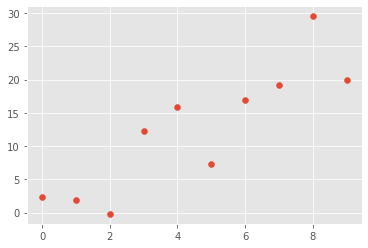

In [108]:
x, y = sim_data()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x, y)

----

# MNIST手写数据识别

## 数据加载

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T

In [3]:
pwd

'D:\\Project-Workspace\\Python-Projects\\DataAnalysis\\ML-Action'

In [4]:
cd ..

D:\Project-Workspace\Python-Projects\DataAnalysis


In [5]:
# 这里必须要使用 transforms.ToTensor() 转换成 tensor，否则每个图片样本是一个 PIL.Image.Image 的对象
# mnist_train = datasets.MNIST(root='./datasets/PyTorch/', train=True, download=True, transform=T.ToTensor())
# mnist_test = datasets.MNIST(root='./datasets/PyTorch/', train=False, download=True, transform=T.ToTensor())

# 用于将tensor压平的匿名函数
flatten = lambda t: torch.flatten(t)
# t = torch.tensor([[1,2],[3,4]])
# print(t)
# print(flatten(t))

# 上面得到的每张图像是 28x28 的矩阵，下面将每张图片进行了拉直，也就是转换成一个 28x28=784 的向量
mnist_train = datasets.MNIST(root='./datasets/PyTorch/', train=True, download=True, transform=T.Compose([T.ToTensor(),T.Lambda(flatten)]))
mnist_test = datasets.MNIST(root='./datasets/PyTorch/', train=False, download=True, transform=T.Compose([T.ToTensor(),T.Lambda(flatten)]))

In [6]:
print(mnist_train.__class__)
print(mnist_train.classes)

# 可以使用下面的语句查看每个样本的类型，这里得到的是一个元组，元组的第一个元素就是对应的第一个图片样本，第二个元素是对应的手写数字值
# 如果没有指定 transform参数，图片样本就是PIL.Image.Image对象，进行了 T.ToTensor() 的转换后，就是一个 Tensor
# mnist_train[0]
# 获取第一个图片样本
# mnist_train[0][0]

# 检查每张图片样本的shape
mnist_train[0][0].shape

<class 'torchvision.datasets.mnist.MNIST'>
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


torch.Size([784])

In [8]:
# 这里的.data属性存储的是没有经过变换之前的数值，所以仍然是28x28
print(mnist_train.data.__class__)
print(mnist_train.data.shape)
print(mnist_train.data[0].shape)

<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
torch.Size([28, 28])


In [443]:
print(mnist_train.targets.__class__)
print(mnist_train.targets.shape)
print(mnist_train.targets[0])
print(mnist_test.data.shape)

<class 'torch.Tensor'>
torch.Size([60000])
tensor(5)
torch.Size([10000, 28, 28])


## DNN模型

这里构建一个 **输入层 + 隐藏层1 + 隐藏层2 + softmax层**，一共4层的神经网络，使用的内容如下：  
+ 每一层的激活函数使用ReLU函数
+ 损失函数使用L2正则项
+ 使用衰减的指数学习率

In [14]:
from torch import nn
from torch import optim

In [15]:
class MnistDNN(nn.Module):
    def __init__(self, input_dim, layer_1_dim, layer_2_dim):
        """
        input_dim指定输入层的节点数
        layer_1_dim指定第一个隐藏层的节点数
        layer_2_dim指定第二个隐藏层的节点数，这也是softmax层和输出层的节点数
        output_dim指定输出层的节点数
        """
        super().__init__()
        self.layer1 = nn.Linear(input_dim, layer_1_dim, bias=True)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(layer_1_dim, layer_2_dim, bias=True)
        self.relu2 = nn.ReLU()
        # softmax层不需要指定节点数，它的节点数和上一层一致，只需要指定在哪个维度上进行softmax就行了
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X, train=False):
        """
        输入X的shape是：batch_size * (28*28)
        """
        layer_1_out = self.relu1(self.layer1(X))
        layer_2_out = self.relu2(self.layer2(layer_1_out))
        # 训练的时候不使用softmax，因为损失函数里会有softmax这一步
        if train:
            y_pred = layer_2_out
        else:
            y_pred = self.softmax(layer_2_out)
        return y_pred

In [16]:
# 输入层节点数
INPUT_NODES = 28*28
# 隐藏层1的节点数
LAYER_1_NODES = 500
# 隐藏层2的节点数，也是输出层节点数
LAYER_2_NODES = 10
# 每批样本数
BATCH_SIZE=500

In [17]:
mnist_train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)

# dataiter = iter(mnist_train_loader)
# batch_data, batch_label = next(dataiter)
# print(batch_data.__class__)
# print(batch_data.shape)
# y_pred = mnist_dnn(batch_data)
# y_pred[0]

### CPU训练

In [18]:
# 这个模型是定义在CPU上的
mnist_dnn = MnistDNN(INPUT_NODES, LAYER_1_NODES, LAYER_2_NODES)
print(mnist_dnn)
# for param, value in mnist_dnn.named_parameters():
#     print("param:", param)
#     print("value:", value)

# 定义损失函数
crossEnt = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.SGD(params=mnist_dnn.parameters(), lr=0.1)

# 定义指数衰减的学习率
scheluer_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

MnistDNN(
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=500, out_features=10, bias=True)
  (relu2): ReLU()
  (softmax): Softmax(dim=1)
)


In [19]:
# 检查模型是否在CUDA上
# 随便取模型中的一个参数，检查参数的 .is_cuda 属性即可
next(mnist_dnn.parameters()).is_cuda

False

In [561]:
%%time
# 这里是使用CPU训练
# 进行训练
for epoch in range(1,11):
    print("----------- trainning on epoch {}--------------------".format(epoch))
    for batch_num, (batch_data, batch_label) in enumerate(mnist_train_loader):
        # 清空梯度
        optimizer.zero_grad()
        # 计算预测值
        y_pred = mnist_dnn(batch_data)
        # 计算损失函数值
        loss = crossEnt(y_pred, batch_label)
        # 计算梯度
        loss.backward()
        # 使用优化器更新参数
        optimizer.step()
        # 更新学习率
        scheluer_exp.step()

        if (batch_num+1) % 40 == 0:
            # 计算新的预测值和损失值
            y_pred = mnist_dnn(batch_data)
            loss = crossEnt(y_pred, batch_label)
            print("batch num {}, Train Cross-Entropy-Loss is: {:.5f}".format(batch_num+1, loss))

----------- trainning on epoch 1--------------------
batch num 40, Train Cross-Entropy-Loss is: 2.30243
batch num 80, Train Cross-Entropy-Loss is: 2.30245
batch num 120, Train Cross-Entropy-Loss is: 2.30299
----------- trainning on epoch 2--------------------
batch num 40, Train Cross-Entropy-Loss is: 2.30243
batch num 80, Train Cross-Entropy-Loss is: 2.30245
batch num 120, Train Cross-Entropy-Loss is: 2.30299
----------- trainning on epoch 3--------------------
batch num 40, Train Cross-Entropy-Loss is: 2.30243
batch num 80, Train Cross-Entropy-Loss is: 2.30245
batch num 120, Train Cross-Entropy-Loss is: 2.30299
----------- trainning on epoch 4--------------------
batch num 40, Train Cross-Entropy-Loss is: 2.30243
batch num 80, Train Cross-Entropy-Loss is: 2.30245
batch num 120, Train Cross-Entropy-Loss is: 2.30299
----------- trainning on epoch 5--------------------
batch num 40, Train Cross-Entropy-Loss is: 2.30243
batch num 80, Train Cross-Entropy-Loss is: 2.30245
batch num 120, Tr

### GPU训练

In [568]:
BATCH_SIZE = 10000
mnist_train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)

In [569]:
# 获取 GPU 设备
gpu_device = torch.device("cuda:0")
# 将模型转移到GPU
# mnist_dnn = mnist_dnn.cuda()
mnist_dnn.to(gpu_device)

# 检查模型是否在CUDA上
next(mnist_dnn.parameters()).is_cuda

True

In [570]:
# 定义损失函数
crossEnt = nn.CrossEntropyLoss()
# 定义优化器
optimizer = optim.SGD(params=mnist_dnn.parameters(), lr=0.1)
# 定义指数衰减的学习率
scheluer_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [571]:
%%time
# 调用GPU计算
for epoch in range(1,11):
    print("----------- trainning on epoch {}--------------------".format(epoch))
    for batch_num, (batch_data, batch_label) in enumerate(mnist_train_loader):
        
        # 这里每次都将数据转移到GPU
        batch_data = batch_data.to(gpu_device)
        batch_label = batch_label.to(gpu_device)
        
        # 清空梯度
        optimizer.zero_grad()
        # 计算预测值
        y_pred = mnist_dnn(batch_data)
        # 计算损失函数值
        loss = crossEnt(y_pred, batch_label)
        # 计算梯度
        loss.backward()
        # 使用优化器更新参数
        optimizer.step()
        # 更新学习率
        scheluer_exp.step()

        if (batch_num+1) % 2 == 0:
            # 计算新的预测值和损失值
            y_pred = mnist_dnn(batch_data)
            loss = crossEnt(y_pred, batch_label)
            print("batch num {}, Train Cross-Entropy-Loss is: {:.5f}".format(batch_num+1, loss))

----------- trainning on epoch 1--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.30167
batch num 4, Train Cross-Entropy-Loss is: 2.30156
batch num 6, Train Cross-Entropy-Loss is: 2.30142
----------- trainning on epoch 2--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.30159
batch num 4, Train Cross-Entropy-Loss is: 2.30154
batch num 6, Train Cross-Entropy-Loss is: 2.30142
----------- trainning on epoch 3--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.30159
batch num 4, Train Cross-Entropy-Loss is: 2.30154
batch num 6, Train Cross-Entropy-Loss is: 2.30142
----------- trainning on epoch 4--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.30159
batch num 4, Train Cross-Entropy-Loss is: 2.30154
batch num 6, Train Cross-Entropy-Loss is: 2.30142
----------- trainning on epoch 5--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.30159
batch num 4, Train Cross-Entropy-Loss is: 2.30154
batch num 6, Train Cross-Entropy-Lo

## CNN：LeNet-5模型

原始的LeNet-5模型总共有7层（不包含输入层）
1. 输入层：32x32x1
2. 卷积层：6 个过滤器，步长为 1，不使用0填充，卷积核为 5x5x1x6，输出尺寸为 32-5+1=28，即 28x28x6
3. 池化层：窗口大小为 2x2，步长为 2，输出尺寸为 14x14x6
4. 卷积层：16 个过滤器，步长为 1，不使用0填充，卷积核为 5x5x6x16，输出尺寸为 14-5+1=10，即 10x10x16
5. 池化层：窗口大小为 2x2，步长为 2，输出尺寸为 5x5x6
6. 全连接层：输出节点个数为 120
7. 全连接层：输出节点个数为 84
8. 全连接层；输出节点个数为 10

在MNIST数据集上的应用就是：
1. 输入层：28x28x1
2. 卷积层：32 个过滤器，步长为 1，**使用0填充**，卷积核为 5x5x1x32，输出尺寸为 28x28x32
3. 池化层：窗口大小为 2x2，步长为 2，**使用0填充**，输出尺寸为 14x14x32
4. 卷积层：64 个过滤器，步长为 1，不使用0填充，卷积核为 5x5x32x64，输出尺寸为 14-5+1=10，即 10x10x64
5. 池化层：窗口大小为 2x2，步长为 2，输出尺寸为 5x5x64
6. 全连接层：节点个数为 512
7. 全连接层：节点个数为 10

In [49]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), stride=1, padding=2, padding_mode='zeros', bias=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=0, bias=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=(5*5*64), out_features=512, bias=True)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=512, out_features=10, bias=True)
        self.relu2 = nn.ReLU()
        
    def forward(self, X):
        layer1 = self.pool1( self.conv1(X) )
        layer2 = self.pool2( self.conv2(layer1) )
        # 需要将layer2输出的 5x5x64 的矩阵拉直成一个向量
        layer2 = self.flatten(layer2)
        layer3 = self.relu1( self.linear1(layer2) )
        layer4 = self.relu2( self.linear2(layer3) )
        return layer4

### CPU训练

In [55]:
# 上面得到的每张图像是 28x28 的矩阵，下面将每张图片进行了拉直，也就是转换成一个 28x28=784 的向量
mnist_train = datasets.MNIST(root='./datasets/PyTorch/', train=True, download=True, transform=T.ToTensor())
mnist_test = datasets.MNIST(root='./datasets/PyTorch/', train=False, download=True, transform=T.ToTensor())

In [55]:
BATCH_SIZE = 100
mnist_train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)

In [50]:
# 这个模型是定义在CPU上的
mnist_cnn = LeNet5()
print(mnist_cnn)
# for param, value in mnist_cnn.named_parameters():
#     print("param:", param)
#     print("value:", value)

# 定义损失函数
crossEnt = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.SGD(params=mnist_cnn.parameters(), lr=0.1)

# 定义指数衰减的学习率
scheluer_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1600, out_features=512, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (relu2): ReLU()
)


In [51]:
# 检查模型是否在CUDA上
# 随便取模型中的一个参数，检查参数的 .is_cuda 属性即可
next(mnist_dnn.parameters()).is_cuda

False

In [56]:
%%time
# 这里是使用CPU训练
for epoch in range(1,11):
    print("----------- trainning on epoch {}--------------------".format(epoch))
    for batch_num, (batch_data, batch_label) in enumerate(mnist_train_loader):
        # 清空梯度
        optimizer.zero_grad()
        # 计算预测值
        y_pred = mnist_cnn(batch_data)
        # 计算损失函数值
        loss = crossEnt(y_pred, batch_label)
        # 计算梯度
        loss.backward()
        # 使用优化器更新参数
        optimizer.step()
        # 更新学习率
        scheluer_exp.step()

        if (batch_num+1) % 200 == 0:
            # 计算新的预测值和损失值
            y_pred = mnist_cnn(batch_data)
            loss = crossEnt(y_pred, batch_label)
            print("batch num {}, Train Cross-Entropy-Loss is: {:.5f}".format(batch_num+1, loss))

----------- trainning on epoch 1--------------------
batch num 200, Train Cross-Entropy-Loss is: 2.28877
batch num 400, Train Cross-Entropy-Loss is: 2.28252
batch num 600, Train Cross-Entropy-Loss is: 2.28452
----------- trainning on epoch 2--------------------
batch num 200, Train Cross-Entropy-Loss is: 2.28877
batch num 400, Train Cross-Entropy-Loss is: 2.28252
batch num 600, Train Cross-Entropy-Loss is: 2.28452
----------- trainning on epoch 3--------------------
batch num 200, Train Cross-Entropy-Loss is: 2.28877
batch num 400, Train Cross-Entropy-Loss is: 2.28252
batch num 600, Train Cross-Entropy-Loss is: 2.28452
----------- trainning on epoch 4--------------------
batch num 200, Train Cross-Entropy-Loss is: 2.28877
batch num 400, Train Cross-Entropy-Loss is: 2.28252
batch num 600, Train Cross-Entropy-Loss is: 2.28452
----------- trainning on epoch 5--------------------
batch num 200, Train Cross-Entropy-Loss is: 2.28877
batch num 400, Train Cross-Entropy-Loss is: 2.28252
batch n

### GPU训练

In [79]:
# 这个模型是定义在CPU上的
mnist_cnn = LeNet5()
print(mnist_cnn)
# for param, value in mnist_cnn.named_parameters():
#     print("param:", param)
#     print("value:", value)

# 定义损失函数
crossEnt = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.SGD(params=mnist_cnn.parameters(), lr=0.1)

# 定义指数衰减的学习率
scheluer_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=1600, out_features=512, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=512, out_features=10, bias=True)
  (relu2): ReLU()
)


In [80]:
# 获取 GPU 设备
gpu_device = torch.device("cuda:0")
# 将模型转移到GPU
# mnist_dnn = mnist_dnn.cuda()
mnist_cnn.to(gpu_device)

# 检查模型是否在CUDA上
next(mnist_cnn.parameters()).is_cuda

True

In [81]:
BATCH_SIZE = 10000
mnist_train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)

In [84]:
%%time
# 调用GPU计算
for epoch in range(1,11):
    print("----------- trainning on epoch {}--------------------".format(epoch))
    for batch_num, (batch_data, batch_label) in enumerate(mnist_train_loader):
        
        # 这里每次都将数据转移到GPU
        batch_data = batch_data.to(gpu_device)
        batch_label = batch_label.to(gpu_device)
        
        # 清空梯度
        optimizer.zero_grad()
        # 计算预测值
        y_pred = mnist_cnn(batch_data)
        # 计算损失函数值
        loss = crossEnt(y_pred, batch_label)
        # 计算梯度
        loss.backward()
        # 使用优化器更新参数
        optimizer.step()
        # 更新学习率
        scheluer_exp.step()

        if (batch_num+1) % 2 == 0:
            # 计算新的预测值和损失值
            y_pred = mnist_cnn(batch_data)
            loss = crossEnt(y_pred, batch_label)
            print("batch num {}, Train Cross-Entropy-Loss is: {:.5f}".format(batch_num+1, loss))

----------- trainning on epoch 1--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.29435
batch num 4, Train Cross-Entropy-Loss is: 2.29463
batch num 6, Train Cross-Entropy-Loss is: 2.29405
----------- trainning on epoch 2--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.29418
batch num 4, Train Cross-Entropy-Loss is: 2.29459
batch num 6, Train Cross-Entropy-Loss is: 2.29404
----------- trainning on epoch 3--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.29418
batch num 4, Train Cross-Entropy-Loss is: 2.29459
batch num 6, Train Cross-Entropy-Loss is: 2.29404
----------- trainning on epoch 4--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.29418
batch num 4, Train Cross-Entropy-Loss is: 2.29459
batch num 6, Train Cross-Entropy-Loss is: 2.29404
----------- trainning on epoch 5--------------------
batch num 2, Train Cross-Entropy-Loss is: 2.29418
batch num 4, Train Cross-Entropy-Loss is: 2.29459
batch num 6, Train Cross-Entropy-Lo

------

# RNN练习

## RNN拟合$sin$函数序列
这里展示一个使用RNN拟合$sin$函数的例子

In [30]:
TRAINING_EXAMPLES = 10000
TESTING_EXAMPLES = 1000
SAMPLE_INTERVAL = 0.01*np.pi
TIME_STEPS = 10  # 序列的长度

# 构造数据集
# 需要注意的是，RNN输入数据的shape=(batch_size, time_steps, input_size)，特别要注意 time_steps 这个维度.
def generate_data(seq):
    """
    从序列seq中进行采样，用 [第i项: TIME_STEPS-1项]作为输入值X， 第 i+TIMES_STEPS 项作为Y值
    """
    X = []
    Y = []
    # 序列的第 i 项和后面的 TIME_STEPS-1 项合在一起作为输入；第 i + TIME_STEPS 项作为输出。
    # 即用sin函数前面的 TIME_STEPS 个点的信息，预测第 i + TIME_STEPS 个点的函数值。
    # 样本数为 序列长度 - TIME_STEPS
    for i in range(len(seq)-TIME_STEPS):
        # X.append([seq[i: (i+TIME_STEPS)]])
        # Y.append([seq[i+TIME_STEPS]])
        X.append(seq[i: (i+TIME_STEPS)])
        Y.append(seq[i+TIME_STEPS])
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

# 确定测试数据起点，这之前都是训练数据集：训练数据集的取值区间是 [0, test_start]，这中间取 TRAINING_EXAMPLES + TIME_STEPS 个点，
test_start = (TRAINING_EXAMPLES + TIME_STEPS) * SAMPLE_INTERVAL
# 确定测试数据集的终点：测试数据集的取值区间是 [test_start, test_end]， 这中间取 TESTING_EXAMPLES + TIME_STEPS 个点
test_end = test_start + (TESTING_EXAMPLES + TIME_STEPS) * SAMPLE_INTERVAL

sin_x_train = np.linspace(0, test_start, TRAINING_EXAMPLES + TIME_STEPS, dtype=np.float32)
sin_y_train = np.sin(sin_x_train)
sin_x_test = np.linspace(test_start, test_end, TESTING_EXAMPLES + TIME_STEPS, dtype=np.float32)
sin_y_test = np.sin(sin_x_test)

# 注意，这里是要用sin值序列的 第i项: TIME_STEPS-1 项 预测 第 i+TIMES_STEPS 项，所以只需要 sin_y_train值，不需要横坐标的值
train_X, train_y = generate_data(sin_y_train)
test_X, test_y = generate_data(sin_y_test)

# 修改一下数据的 shape
train_X = train_X.reshape(TRAINING_EXAMPLES, TIME_STEPS, 1)
train_y = train_y.reshape(TRAINING_EXAMPLES, 1)
test_X = test_X.reshape(TESTING_EXAMPLES, TIME_STEPS, 1)
test_y = test_y.reshape(TESTING_EXAMPLES, 1)

train_X = torch.tensor(train_X)
train_y = torch.tensor(train_y)
test_X = torch.tensor(test_X)
test_y = torch.tensor(test_y)

# 一共10000个样本，每个训练样本是一个长度(time_step)=10的 sequence，sequence中每个位置的值是一个长度=1的向量（也就是标量）
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

torch.Size([10000, 10, 1])
torch.Size([10000, 1])
torch.Size([1000, 10, 1])
torch.Size([1000, 1])


In [31]:
# 测试一下数据和RNN
# input_size=1，隐藏层是 长度=5 的向量，单层、单向 RNN
rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, bidirectional=False, nonlinearity='relu', bias=False, batch_first=True)

res = rnn(train_X)
# 输出层
print(res[0].shape)
# 隐藏层（状态层）
print(res[1].shape)

torch.Size([10000, 10, 5])
torch.Size([1, 10000, 5])


In [32]:
class RnnSin(nn.Module):
    def __init__(self):
        super().__init__()
        # 单层、单向RNN，隐藏层向量维度 = 5
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, nonlinearity='relu', bias=False, batch_first=True, bidirectional=False)
        # 将RNN的输出拉平
        self.flatten = nn.Flatten()
        # 最后用一个全连接层，将结果转成一个实数
        self.linear = nn.Linear(in_features=50, out_features=1, bias=True)

    def forward(self, X):
        rnn_out = self.rnn(X)
        rnn_out_flat = self.flatten(rnn_out[0])
        out = self.linear(rnn_out_flat)
        return out

In [35]:
# 初始化模型
sin_rnn = RnnSin()
# 定义损失函数
mse = nn.MSELoss()
# 定义优化器
optimizer = optim.SGD(params=sin_rnn.parameters(), lr=0.1)

for epoch in range(1, 31):
    # 获取预测值
    sin_pred = sin_rnn(train_X)
    # sin_pred.shape
    # 清空梯度
    optimizer.zero_grad()
    # 计算损失函数值
    loss = mse(sin_pred, train_y)
    # 计算梯度
    loss.backward()
    # 使用优化器更新参数
    optimizer.step()
    # 新的MSE损失
    train_pred_y = sin_rnn(train_X)
    train_loss = mse(train_pred_y, train_y)
    test_pred_y = sin_rnn(test_X)
    test_loss = mse(test_pred_y, test_y)
    # print(loss)
    print("epoch {:2} ---- training MSE-Loss  is：{:.4f}".format(epoch, train_loss))
    print("epoch {:2} ---- testing  MSE-Loss  is：{:.4f}".format(epoch, test_loss))

epoch  1 ---- training MSE-Loss  is：0.3923
epoch  1 ---- testing  MSE-Loss  is：0.3922
epoch  2 ---- training MSE-Loss  is：0.3347
epoch  2 ---- testing  MSE-Loss  is：0.3347
epoch  3 ---- training MSE-Loss  is：0.2766
epoch  3 ---- testing  MSE-Loss  is：0.2765
epoch  4 ---- training MSE-Loss  is：0.2257
epoch  4 ---- testing  MSE-Loss  is：0.2256
epoch  5 ---- training MSE-Loss  is：0.1871
epoch  5 ---- testing  MSE-Loss  is：0.1870
epoch  6 ---- training MSE-Loss  is：0.1597
epoch  6 ---- testing  MSE-Loss  is：0.1597
epoch  7 ---- training MSE-Loss  is：0.1391
epoch  7 ---- testing  MSE-Loss  is：0.1390
epoch  8 ---- training MSE-Loss  is：0.1224
epoch  8 ---- testing  MSE-Loss  is：0.1224
epoch  9 ---- training MSE-Loss  is：0.1089
epoch  9 ---- testing  MSE-Loss  is：0.1089
epoch 10 ---- training MSE-Loss  is：0.0977
epoch 10 ---- testing  MSE-Loss  is：0.0977
epoch 11 ---- training MSE-Loss  is：0.0885
epoch 11 ---- testing  MSE-Loss  is：0.0885
epoch 12 ---- training MSE-Loss  is：0.0808
epoch 12 --

## IMDB影评数据集分类

In [89]:
from sklearn.datasets import load_files
import spacy
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

## 数据集加载处理

In [155]:
class ImdbDataset(Dataset):
    def __init__(self, filepath, part=None):
        super(ImdbDataset, self).__init__()
        self.filepath = filepath
        self.__nlp = spacy.load("en_core_web_sm")
        self.doc_vector, self.label = self.transform(filepath, part)

    def transform(self, filepath, part):
        text_data = load_files(filepath)
        text_list, label = text_data.data, text_data.target
        if part is not None:
            text_list = text_list[:part]
            label = label[:part]
        text = [doc.decode("utf-8").replace("<br />", " ") for doc in text_list]
        sentence_vec = [self.sentence2vector(self.__nlp(doc)) for doc in text]
        # 上面得到的 sentence_vec 中，每个句子的长度都不一样，需要选择最短的句子做截断处理-----这个处理的不好
        # seq_length = min([sentence.shape[0] for sentence in sentence_vec])
        # sentence_vec_trunc = [sentence[:seq_length, :] for sentence in sentence_vec]
        # doc_len = [sentence.shape for sentence in sentence_vec_trunc]
        # print("seq_length", seq_length)
        # print("doc_len", doc_len)
        # doc_vector = np.array(sentence_vec_truc)
        
        # 选择句子的平均长度，不足的进行padding
        seq_length = int(np.mean(([sentence.shape[0] for sentence in sentence_vec])))
        sentence_vec_pad = [self.sentence_vector_padding(sentence, seq_length) for sentence in sentence_vec]
        doc_vector = np.array(sentence_vec_pad)
        return doc_vector, label

    def sentence2vector(self, doc):
        """
        用于从 sentence 中过滤出有用的word
        @param sentence: spacy的doc对象，封装了一个句子
        @return: 句子中有效单词所组成的 词向量矩阵,
        """
        doc_matrix = doc.tensor
        # 接下来要从上面剔除掉 标点符号 等无效部分的词向量
        index_list = []
        for token in doc:
            if token.is_stop or token.is_punct or token.is_currency:
                continue
            else:
                index_list.append(token.i)
        result = doc_matrix[index_list, :]
        # print(result.shape)
        return result

    def sentence_vector_padding(self, sen_vec, seq_length):
        """
        对每个句子对应的词向量矩阵进行填充，保证句子长度一样
        """
        if sen_vec.shape[0] >= seq_length:
            return sen_vec[:seq_length, :]
        else:
            pad_len = int(seq_length-sen_vec.shape[0])
            sen_vec_pad = np.pad(array=sen_vec, pad_width=((0,pad_len),(0,0)), mode='constant', constant_values=0)
            return sen_vec_pad

    def __len__(self):
        return self.doc_vector.shape[0]

    def __getitem__(self, item):
        return self.doc_vector[item, :, :], self.label[item]

In [130]:
# 读取数据集
imdb_train = ImdbDataset(filepath='./datasets/aclImdb/train/', part=2000)
imdb_test = ImdbDataset(filepath='./datasets/aclImdb/test/', part=200)

doc_vector = imdb_train.doc_vector
print(doc_vector.shape)
doc_label = imdb_train.label
print(doc_label.shape)

# 构建训练数据集的加载器
batch_size = 200
imdb_train_loader = DataLoader(dataset=imdb_train, batch_size=batch_size)

In [132]:
iter_batch = iter(imdb_train_loader)
X, y = next(iter_batch)
print(X.__class__)
print(X.shape)
print(y.__class__)
print(y.shape)

<class 'torch.Tensor'>
torch.Size([200, 107, 96])
<class 'torch.Tensor'>
torch.Size([200])


## LSTM模型

In [158]:
class ImdbLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_length, num_layers):
        super().__init__()
        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=seq_length*hidden_size, out_features=2, bias=True)

    def forward(self, X):
        lstm_out = self.lstm_layer(X)
        lstm_flatten = self.flatten(lstm_out[0])
        y_pred = self.linear(lstm_flatten)
        return y_pred

### CPU训练

In [175]:
# 初始化模型
lstm_rnn = ImdbLSTM(input_size=96, hidden_size=48, seq_length=107, num_layers=1)
# 定义损失函数
crossEnt = nn.CrossEntropyLoss()
# 定义优化器
optimizer = optim.SGD(params=lstm_rnn.parameters(), lr=0.1)

# 测试
# out = lstm_rnn(X)
# loss = crossEnt(out, y.long())

# 测试数据集，此时是放在内存中供CPU使用的
test_data, test_label = imdb_test.doc_vector, imdb_test.label
test_data = torch.tensor(test_data)
test_label = torch.tensor(test_label)

In [176]:
%%time
# 开始迭代训练
for epoch in range(1,11):
    for batch_id, (X, y) in enumerate(imdb_train_loader):
        y_pred = lstm_rnn(X)
        optimizer.zero_grad()
        loss = crossEnt(y_pred, y.long())
        loss.backward()
        optimizer.step()

        y_pred_new = lstm_rnn(X)
        train_loss = crossEnt(y_pred_new, y.long())
        y_test = lstm_rnn(test_data)
        test_loss = crossEnt(y_test, test_label.long())
        
        if (batch_id+1) % 2 == 0:
            print("epoch {:2}, batch {:2}, train_loss: {:.4f}".format(epoch, batch_id+1, train_loss))
            print("epoch {:2}, batch {:2}, test_loss:  {:.4f}".format(epoch, batch_id+1, test_loss))

epoch  1, batch  2, train_loss: 0.6756
epoch  1, batch  2, test_loss:  0.7166
epoch  1, batch  4, train_loss: 0.6747
epoch  1, batch  4, test_loss:  0.6938
epoch  1, batch  6, train_loss: 0.6806
epoch  1, batch  6, test_loss:  0.6999
epoch  1, batch  8, train_loss: 0.6725
epoch  1, batch  8, test_loss:  0.6916
epoch  1, batch 10, train_loss: 0.6630
epoch  1, batch 10, test_loss:  0.6985
epoch  2, batch  2, train_loss: 0.6616
epoch  2, batch  2, test_loss:  0.7105
epoch  2, batch  4, train_loss: 0.6572
epoch  2, batch  4, test_loss:  0.6913
epoch  2, batch  6, train_loss: 0.6590
epoch  2, batch  6, test_loss:  0.6925
epoch  2, batch  8, train_loss: 0.6521
epoch  2, batch  8, test_loss:  0.6889
epoch  2, batch 10, train_loss: 0.6431
epoch  2, batch 10, test_loss:  0.6967
epoch  3, batch  2, train_loss: 0.6464
epoch  3, batch  2, test_loss:  0.7009
epoch  3, batch  4, train_loss: 0.6411
epoch  3, batch  4, test_loss:  0.6896
epoch  3, batch  6, train_loss: 0.6410
epoch  3, batch  6, test_

### GPU训练

In [177]:
# 初始化模型
lstm_rnn = ImdbLSTM(input_size=96, hidden_size=48, seq_length=107, num_layers=1)
# 定义损失函数
crossEnt = nn.CrossEntropyLoss()
# 定义优化器
optimizer = optim.SGD(params=lstm_rnn.parameters(), lr=0.1)

# 获取 GPU 设备
gpu_device = torch.device("cuda:0")
# 将模型转移到GPU
lstm_rnn.to(gpu_device)

# 注意，测试数据也要放到GPU上
test_data = test_data.to(gpu_device)
test_label = test_label.to(gpu_device)

# 检查模型是否在CUDA上
next(lstm_rnn.parameters()).is_cuda

True

In [178]:
%%time
# 开始迭代训练
for epoch in range(1,11):
    for batch_id, (X, y) in enumerate(imdb_train_loader):
        
        # 将数据转移到GPU
        X = X.to(gpu_device)
        y = y.to(gpu_device)
        
        y_pred = lstm_rnn(X)
        optimizer.zero_grad()
        loss = crossEnt(y_pred, y.long())
        loss.backward()
        optimizer.step()

        y_pred_new = lstm_rnn(X)
        train_loss = crossEnt(y_pred_new, y.long())
        y_test = lstm_rnn(test_data)
        test_loss = crossEnt(y_test, test_label.long())
        
        if (batch_id+1) % 2 == 0:
            print("epoch {:2}, batch {:2}, train_loss: {:.4f}".format(epoch, batch_id+1, train_loss))
            print("epoch {:2}, batch {:2}, test_loss:  {:.4f}".format(epoch, batch_id+1, test_loss))

epoch  1, batch  2, train_loss: 0.6741
epoch  1, batch  2, test_loss:  0.7017
epoch  1, batch  4, train_loss: 0.6768
epoch  1, batch  4, test_loss:  0.6898
epoch  1, batch  6, train_loss: 0.6704
epoch  1, batch  6, test_loss:  0.6894
epoch  1, batch  8, train_loss: 0.6667
epoch  1, batch  8, test_loss:  0.6890
epoch  1, batch 10, train_loss: 0.6708
epoch  1, batch 10, test_loss:  0.6969
epoch  2, batch  2, train_loss: 0.6579
epoch  2, batch  2, test_loss:  0.6974
epoch  2, batch  4, train_loss: 0.6600
epoch  2, batch  4, test_loss:  0.6874
epoch  2, batch  6, train_loss: 0.6513
epoch  2, batch  6, test_loss:  0.6870
epoch  2, batch  8, train_loss: 0.6474
epoch  2, batch  8, test_loss:  0.6872
epoch  2, batch 10, train_loss: 0.6515
epoch  2, batch 10, test_loss:  0.6940
epoch  3, batch  2, train_loss: 0.6431
epoch  3, batch  2, test_loss:  0.6947
epoch  3, batch  4, train_loss: 0.6446
epoch  3, batch  4, test_loss:  0.6858
epoch  3, batch  6, train_loss: 0.6340
epoch  3, batch  6, test_